In [8]:
!pip install numpy
!pip install matplotlib
!brew install cmake
!pip install cvxpy


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: pip install --upgrade pip
Running `brew update --auto-update`...
==> Homebrew collects anonymous analytics.
Read the analytics documentation (and how to opt-out) here:
  https://docs.brew.sh/Analytics
No analytics have been recorded yet (nor will be during this `brew` run).

==> Downloading https://formulae.brew.sh/api/formula_tap_migrations.jws.json
######################################################################### 100.0%
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
adb-enhanced                             ls-lint
alass                                    mailpit
argparse                                 mariadb@10.11
bacon                                    minigraph
bbot                                     mvt
bfs                       

In [159]:
# requirements
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv
import pdb
import numpy.linalg as LA

# Datasets

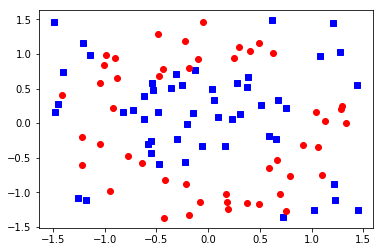

In [ ]:
# dataset 1
np.random.seed(123)
n = 100
x_d1 = 3 * (np.random.rand(n, 2)-0.5)
radius = x_d1[:,0]**2 + x_d1[:,1]**2
y_d1 = (radius > 0.7 + 0.1 * np.random.randn(n)) &( radius < 2.2 + 0.1 * np.random.randn(n))
y_d1 = 2 * y_d1 -1

plt.plot(x_d1[y_d1 < 0, 0],  x_d1[y_d1 < 0, 1], 'bs')
plt.plot(x_d1[y_d1 > 0, 0],  x_d1[y_d1 > 0, 1], 'ro')

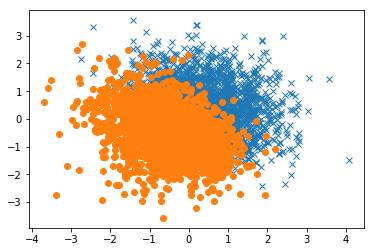

In [ ]:
# dataset 2
n = 4000
omega = np.random.randn()
noise = 0.8 * np.random.randn(n)

x_d2 = np.random.randn(n, 2) + 0
y_d2 = 2 * (omega * x_d2[:,0] + x_d2[:,1] + noise > 0) - 1

plt.plot(np.extract(y_d2>0,x_d2[:,0]),np.extract(y_d2>0,x_d2[:,1]), 'x')
plt.plot(np.extract(y_d2<0,x_d2[:,0]),np.extract(y_d2<0,x_d2[:,1]), 'o')

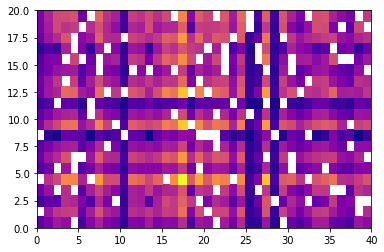

In [ ]:
#dataset3
np.random.seed(1234)
m = 20
n = 40
r = 2
A = np.dot(np.random.rand(m, r), np.random.rand(r, n)).flatten()
ninc = 100
Q = np.random.permutation(m * n)[:ninc]
A[Q] = None
A = A.reshape(m, n)

plt.pcolor(A, cmap=plt.cm.plasma)

In [ ]:
# dataset 4
n = 200
x_d4 = 3 * (np.random.rand(n, 4) - 0.5)
y_d4 = (2 * x_d4[:, 0] - 1 * x_d4[:,1] + 0.5 + 0.5 * np.random.randn(n)) > 0
y_d4 = 2 * y_d4 -1

In [ ]:
# dataset 5
n = 200
x_d5 = 3 * (np.random.rand(n, 4) - 0.5)
W = np.array([[ 2,  -1, 0.5,],
              [-3,   2,   1,],
              [ 1,   2,   3]])
y_d5 = np.argmax(np.dot(np.hstack([x_d5[:,:2], np.ones((n, 1))]), W.T)
                        + 0.5 * np.random.randn(n, 3), axis=1)

In [ ]:
# dataset 6
d_d6 = 200
n_d6 = 180

# we consider 5 groups where each group has 40 attributes
groupSize = 5
attrSize = 40
g_d6 = np.arange(groupSize*attrSize).reshape(groupSize,-1)

x_d6 = np.random.randn(n_d6, d_d6)
noise_d6 = 0.5

# we consider feature in group 1 and group 2 is activated.
w_d6 = np.vstack([20 * np.random.randn(80, 1),
                 np.zeros((120, 1)),
                 5 * np.random.rand()])
x_d6_tilde = np.hstack([x_d6, np.ones((n_d6, 1))])
y_d6 = np.dot(x_d6_tilde, w_d6) + noise_d6 * np.random.randn(n_d6, 1)

# Problem 1

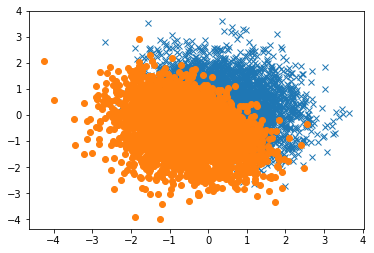

In [ ]:
# requirement
import numpy as np
import matplotlib.pyplot as plt
import cvxpy


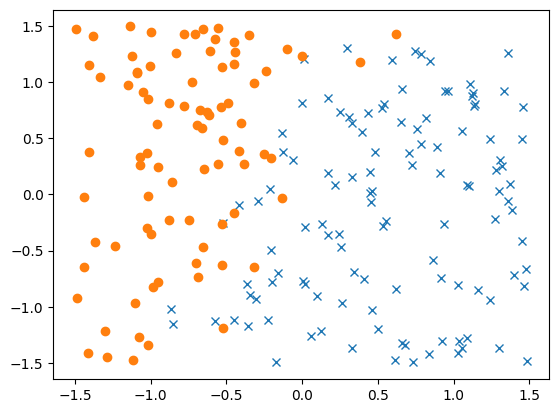

In [28]:
# dataset 4
n = 200
x_d4 = 3 * (np.random.rand(n, 4) - 0.5)
y_d4 = (2 * x_d4[:, 0] - 1 * x_d4[:,1] + 0.5 + 0.5 * np.random.randn(n)) > 0
y_d4 = 2 * y_d4 -1
plt.plot(np.extract(y_d4>0,x_d4[:,0]),np.extract(y_d4>0,x_d4[:,1]), 'x')
plt.plot(np.extract(y_d4<0,x_d4[:,0]),np.extract(y_d4<0,x_d4[:,1]), 'o')

In [111]:
# objective function
def J(x: np.ndarray, y: np.ndarray, w: np.ndarray, penalty_weight: float):
    loss = penalty_weight * w.T @ w
    for xi, yi in zip(x, y):
        # pdb.set_trace()
        loss += np.log(1 + np.exp(-yi*w.T@xi))
    return loss

def dJ(x: np.ndarray, y: np.ndarray, w: np.ndarray, penalty_weight: float):
    grad = 2 * penalty_weight * w
    for xi, yi in zip(x, y):
        grad += -yi * np.exp(-yi*w.T@xi) * xi / (1 + np.exp(-yi*w.T@xi))
    return grad

def HJ(x: np.ndarray, y: np.ndarray, w: np.ndarray, penalty_weight: float):
    H = 2 * penalty_weight * np.identity(len(x[0]))
    for xi, yi in zip(x, y):
        H += yi**2 * np.exp(-yi*w.T@xi) * xi.reshape(-1, 1)@xi.T.reshape(1, -1) / (1 + np.exp(-yi*w.T@xi))**2
    return H

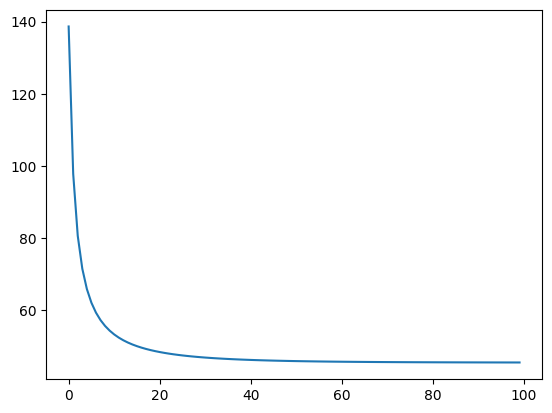

In [122]:
# implement batch steepest gradient method here
# パラメータ
eta = 0.01
max_iter = 100
# w = np.random.rand(200)
w = np.zeros(4)
penalty_weight = 0.1

# データ準備
w_hist_batch = np.zeros((max_iter, 4))
loss_hist_batch = np.zeros(max_iter) # to store the history of loss J(w_t)
x = x_d4
y = y_d4

for i in range(max_iter):
    w_hist_batch[i] = w
    loss_hist_batch[i] = J(x, y, w, penalty_weight)
    w += - eta * dJ(x, y, w, penalty_weight)

# plot the result
fig = plt.figure()
plt.plot(loss_hist_batch)
fig.savefig('data/1-2-steepest.png')

/var/folders/p1/xvkx0rdn0p9_8l0p22r9ykqm0000gp/T/ipykernel_16355/348015261.py:18: RuntimeWarning: overflow encountered in scalar power
  H += yi**2 * np.exp(-yi*w.T@xi) * xi.reshape(-1, 1)@xi.T.reshape(1, -1) / (1 + np.exp(-yi*w.T@xi))**2
/var/folders/p1/xvkx0rdn0p9_8l0p22r9ykqm0000gp/T/ipykernel_16355/348015261.py:6: RuntimeWarning: overflow encountered in exp
  loss += np.log(1 + np.exp(-yi*w.T@xi))
/var/folders/p1/xvkx0rdn0p9_8l0p22r9ykqm0000gp/T/ipykernel_16355/348015261.py:18: RuntimeWarning: overflow encountered in exp
  H += yi**2 * np.exp(-yi*w.T@xi) * xi.reshape(-1, 1)@xi.T.reshape(1, -1) / (1 + np.exp(-yi*w.T@xi))**2
/var/folders/p1/xvkx0rdn0p9_8l0p22r9ykqm0000gp/T/ipykernel_16355/348015261.py:18: RuntimeWarning: invalid value encountered in divide
  H += yi**2 * np.exp(-yi*w.T@xi) * xi.reshape(-1, 1)@xi.T.reshape(1, -1) / (1 + np.exp(-yi*w.T@xi))**2
/var/folders/p1/xvkx0rdn0p9_8l0p22r9ykqm0000gp/T/ipykernel_16355/348015261.py:12: RuntimeWarning: overflow encountered in exp
 

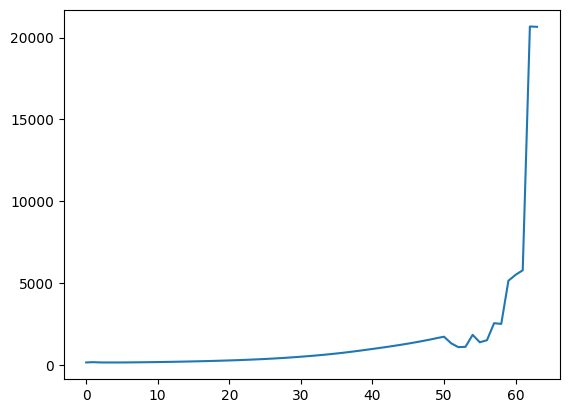

In [127]:
# implement Newton based method here
# パラメータ
eta = 0.01
max_iter = 100
# w = np.random.rand(4)
w = np.zeros(4)
penalty_weight = 0.01

# データ準備
w_hist_newton = np.zeros((max_iter, 4))
loss_hist_newton = np.zeros(max_iter) # to store the history of loss J(w_t)
x = x_d4
y = y_d4

for i in range(max_iter):
    w_hist_newton[i] = w
    loss_hist_newton[i] = J(x, y, w, penalty_weight)
    w += - eta * HJ(x, y, w, penalty_weight)**-1 @ dJ(x, y, w, penalty_weight)
    
# plot the result
fig = plt.figure()
plt.plot(loss_hist_newton)
fig.savefig('data/1-2-newton.png')

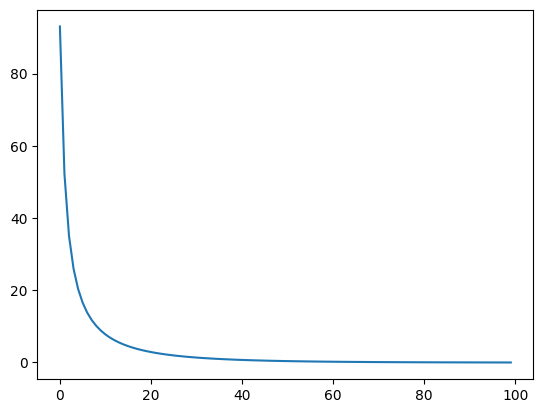

In [128]:
# plot the result
loss_hist_batch = loss_hist_batch - loss_hist_batch[-1]
loss_hist_newton = loss_hist_newton - loss_hist_newton[-1]
fig = plt.figure()
plt.plot(loss_hist_batch)
plt.plot(loss_hist_newton)
fig.savefig('data/1-2-compare.png')

# Problem 2

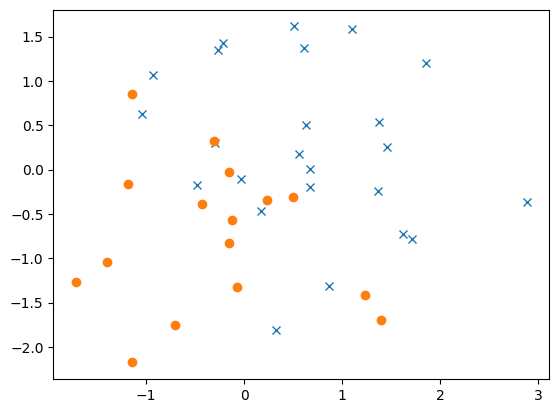

In [208]:
# requirement
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv

# prepare dataset
np.random.seed(3846)
n = 40
omega = np.random.randn()
noise = 0.8 * np.random.randn(n)

x_pro2 = np.random.randn(n, 2) + 0
y_pro2 = 2 * (omega * x_pro2[:,0] + x_pro2[:,1] + noise > 0) - 1

plt.plot(np.extract(y_pro2>0,x_pro2[:,0]),np.extract(y_pro2>0,x_pro2[:,1]), 'x')
plt.plot(np.extract(y_pro2<0,x_pro2[:,0]),np.extract(y_pro2<0,x_pro2[:,1]), 'o')

In [129]:
# (1)
# condition
A = np.array([[  3, 0.5],
              [0.5,   1]])
mu = np.array([[1],
               [2]])

In [156]:
def f(w: np.ndarray, mu: np.ndarray, A:np.ndarray, lam: float):
    return 1/2 * (w-mu).T@A@(w-mu) + lam * w.sum()

def df(w: np.ndarray, mu:np.ndarray, A:np.ndarray):
    '''
    2次形式部分の微分
    '''
    return 1/2 * (A + A.T)@(w - mu)

def prox(y: float, eta: float, lam: float):
    if(y>eta*lam):
        return y - eta * lam
    elif((-eta*lam <= y) and (y <= eta*lam)):
        return 0
    else:
        return y + eta * lam

/var/folders/p1/xvkx0rdn0p9_8l0p22r9ykqm0000gp/T/ipykernel_16355/3997095275.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obj_hist[int(lam)][i] = f(w, mu, A, lam)
/var/folders/p1/xvkx0rdn0p9_8l0p22r9ykqm0000gp/T/ipykernel_16355/3997095275.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/p1/xvkx0rdn0p9_8l0p22r9ykqm0000gp/T/ipykernel_16355/3997095275.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


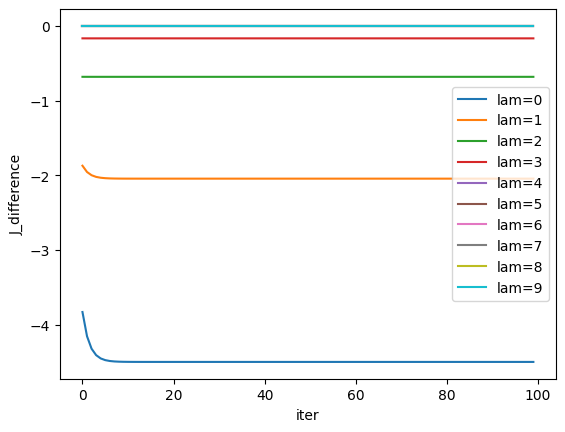

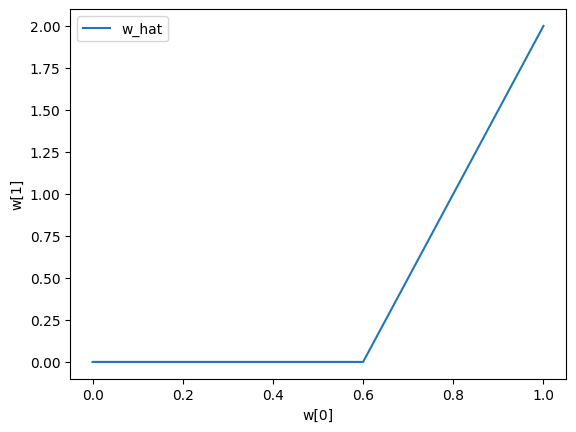

In [210]:
max_iter = 100
lams = np.arange(0, 10.1, 0.1)
obj_hist = np.zeros((11, max_iter))
w_hat_lam = np.zeros((len(lams), 2, 1))
w: np.ndarray = np.zeros((len(mu), 1))

prox_vec_func = np.vectorize(prox)

eigs, _ = LA.eig(A)
eta = np.max(eigs)**-1


for lam_idx, lam in enumerate(lams):
  # init
  w: np.ndarray = np.zeros((len(mu), 1))
  
  ### implement PG ###
  for i in range(max_iter):
    y: np.ndarray = w - eta * df(w, mu, A)
    w = prox_vec_func(y, eta, lam)
    if lam.is_integer():
      obj_hist[int(lam)][i] = f(w, mu, A, lam)
    
  # w_hat log
  w_hat_lam[lam_idx] = w
  
fig, ax = plt.subplots()
for i in range(10):
  ax.plot(obj_hist[i] - obj_hist[-1], label=f'lam={i}')
ax.set_xlabel('iter')
ax.set_ylabel('J_difference')
# ax.set_yscale('log')
ax.legend()
fig.show()
fig.savefig('data/2-1-J_difference.png')

fig, ax = plt.subplots()
ax.plot(w_hat_lam[:,0], w_hat_lam[:,1], label='w_hat')
ax.set_xlabel('w[0]')
ax.set_ylabel('w[1]')
ax.legend()
fig.show()
fig.savefig('data/2-1-w_hat.png')

# plt.plot(lams, w_hat_lam)

In [211]:
x_pro2

array([[-1.04570795,  0.62938478],
       [ 1.39360667, -1.69404845],
       [-0.15246531, -0.02653931],
       [-0.07048495, -1.32820421],
       [-0.15397019, -0.82632224],
       [-1.71668304, -1.27040133],
       [ 0.86494725, -1.31105726],
       [ 0.55735478,  0.18143416],
       [-0.92592608,  1.06679639],
       [ 0.50449487, -0.3143612 ],
       [-0.42499295, -0.38223794],
       [ 2.8873852 , -0.36544457],
       [-1.39785418, -1.03983032],
       [ 0.61072267,  1.37041198],
       [ 0.32317596, -1.81234168],
       [ 0.67289501,  0.01261206],
       [-0.29219776,  0.29577637],
       [-0.02683252, -0.10058351],
       [-0.30976799,  0.32508422],
       [-0.70844429, -1.75695657],
       [-1.14526982, -2.1758266 ],
       [-0.47987122, -0.16931117],
       [ 1.10535992,  1.58270908],
       [ 0.17644071, -0.46792028],
       [ 1.45971416,  0.26048186],
       [ 0.51128648,  1.61504761],
       [-1.14649211,  0.85298772],
       [ 1.36570578, -0.24351714],
       [ 1.62655842,

In [216]:
# (2)
# condition
A = np.array([[  3, 0.5],
              [0.5,   1]])
mu = np.zeros((len(x_pro2[0]),1))
for mu_idx in range(len(mu)):
    xiyi_sum = x_pro2[:, mu_idx]@y_pro2
    xi_2_sum = x_pro2[:, mu_idx]@x_pro2[:, mu_idx]
    mu[mu_idx] = xiyi_sum/xi_2_sum
mu

array([[0.46736587],
       [0.44284026]])

/var/folders/p1/xvkx0rdn0p9_8l0p22r9ykqm0000gp/T/ipykernel_16355/1062051408.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  obj_hist[i] = f(w, mu, A, lam)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/p1/xvkx0rdn0p9_8l0p22r9ykqm0000gp/T/ipykernel_16355/1062051408.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


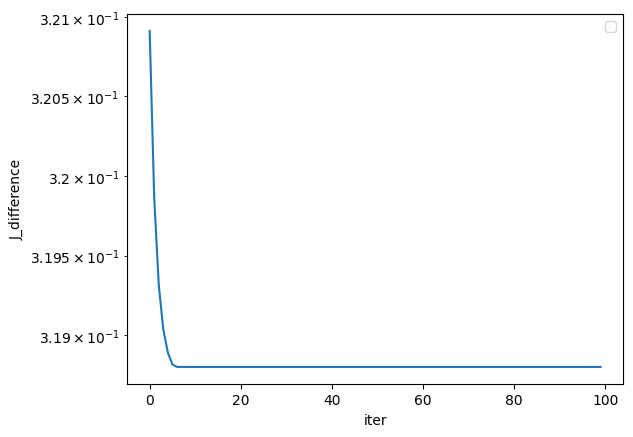

In [222]:
max_iter = 100
lam = 0.5
obj_hist = np.zeros(max_iter)
w: np.ndarray = np.zeros((len(mu), 1))

prox_vec_func = np.vectorize(prox)

eigs, _ = LA.eig(A)
eta = np.max(eigs)**-1


# init
w: np.ndarray = np.zeros((len(mu), 1))

### implement PG ###
for i in range(max_iter):
  y: np.ndarray = w - eta * df(w, mu, A)
  w = prox_vec_func(y, eta, lam)
  # log
  obj_hist[i] = f(w, mu, A, lam)

  
fig, ax = plt.subplots()
ax.plot(obj_hist)
ax.set_xlabel('iter')
ax.set_ylabel('J_difference')
ax.set_yscale('log')
ax.legend()
fig.show()
fig.savefig('data/2-2-J_difference.png')

## example of group lasso (using dataset 6)

In [ ]:
import cvxpy as cv
import matplotlib.pyplot as plt

def mldivide(A, b):
  piA = np.linalg.pinv(A)
  x = np.dot(piA, b)
  return x

# run the cell which preparing dataset 6 before run this cell
y = y_d6
x_tilde = x_d6_tilde
w = w_d6
noise = noise_d6
n = n_d6
d = d_d6
g = g_d6

lam = 1.0
wridge = mldivide(np.dot(x_tilde.T, x_tilde) + lam * np.eye(d+1),
                  np.dot(x_tilde.T, y))

# cvx
west = cv.Variable((d+1,1))
obj_fn = \
  0.5 / n * cv.quad_form(x_tilde * west - y, np.eye(x_tilde.shape[0])) + \
  lam * (cv.norm(west[g[0]], 2.0) + \
         cv.norm(west[g[1]], 2.0) + \
         cv.norm(west[g[2]], 2.0) + \
         cv.norm(west[g[3]], 2.0) + \
         cv.norm(west[g[4]], 2.0) )

objective = cv.Minimize(obj_fn)
constraints = []

prob = cv.Problem(objective, constraints)
result = prob.solve(solver=cv.CVXOPT)

# test
x_test = np.random.randn(n, d)
x_test_tilde = np.hstack([x_test, np.ones((n, 1))])
y_test = np.dot(x_test_tilde, w) + noise * np.random.randn(n, 1)
y_pred = np.dot(x_test_tilde, west.value)
print(np.mean((y_pred - y_test)**2))

8.659234266599729


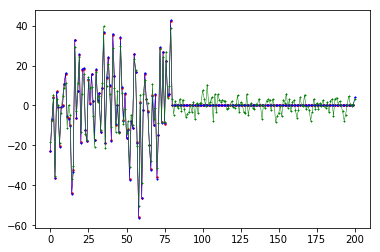

In [ ]:
plt.plot(west.value[0:d], 'r-o', markersize=1.5, linewidth=0.5)
plt.plot(w, 'b-*', markersize=1.5, linewidth=0.5)
plt.plot(wridge, 'g-+', markersize=1.5, linewidth=0.5)

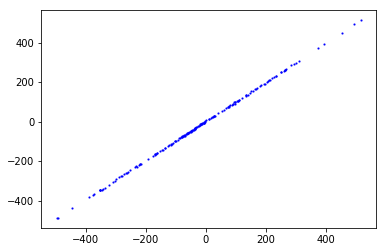

In [ ]:
plt.plot(y_test, y_pred, 'bs', markersize=1)

In [ ]:
print('carinality of w hat: %d'%sum(np.abs(west.value) < 0.01))
print('carinality of w ground truth: %d'%sum(np.abs(w) < 0.01))

carinality of w hat: 120
carinality of w ground truth: 120
